In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
%matplotlib inline

In [2]:
"""
Airports
Airport ID 	Unique OpenFlights identifier for this airport.
Name 	Name of airport. May or may not contain the City name.
City 	Main city served by airport. May be spelled differently from Name.
Country 	Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.
IATA 	3-letter IATA code. Null if not assigned/unknown.
ICAO 	4-letter ICAO code.
Null if not assigned.
Latitude 	Decimal degrees, usually to six significant digits. Negative is South, positive is North.
Longitude 	Decimal degrees, usually to six significant digits. Negative is West, positive is East.
Altitude 	In feet.
Timezone 	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
DST 	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time
Tz database time zone 	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".
Type 	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.
Source 	Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included.

Routes
Airline 	2-letter (IATA) or 3-letter (ICAO) code of the airline.
Airline ID 	Unique OpenFlights identifier for airline (see Airline).
Source airport 	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
Source airport ID 	Unique OpenFlights identifier for source airport (see Airport)
Destination airport 	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
Destination airport ID 	Unique OpenFlights identifier for destination airport (see Airport)
Codeshare 	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
Stops 	Number of stops on this flight ("0" for direct)
Equipment 	3-letter codes for plane type(s) generally used on this flight, separated by spaces
"""
None

In [3]:
airports = pd.read_csv('airports.dat', header=None, names=['AirportID', 'Name', 'Country', 'City', 
                                              'IATA', 'ICAO', 'Latitude', 'Longitude',
                                             'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat', header=None, names=['Airline', 'AirlineID', 'Source', 
                                                       'SourceID', 'Dest', 'DestID',
                                                      'Codeshare', 'Stops', 'Equipment'])

In [4]:
routes.head()

Airline AirlineID Source SourceID Dest DestID Codeshare  Stops Equipment
0      2B       410    AER     2965  KZN   2990       NaN      0       CR2
1      2B       410    ASF     2966  KZN   2990       NaN      0       CR2
2      2B       410    ASF     2966  MRV   2962       NaN      0       CR2
3      2B       410    CEK     2968  KZN   2990       NaN      0       CR2
4      2B       410    CEK     2968  OVB   4078       NaN      0       CR2

In [5]:
routes.head()
def deg2rad(deg):
    return deg*(np.pi/180)

def get_distnace(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = deg2rad(lat2-lat1)
    dlon = deg2rad(lon2-lon1)
    a = np.power(np.sin(dlat/2),2) + \
        np.cos(deg2rad(lat1))*np.cos(deg2rad(lat2))*np.power(np.sin(dlon/2),2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R*c

In [6]:
locations = airports[['AirportID', 'Latitude', 'Longitude']].set_index('AirportID').to_dict()

In [7]:
dest_frequency = routes['DestID'].value_counts()
source_frequency = routes['SourceID'].value_counts()

dest_frequency = dest_frequency.reset_index()
dest_frequency.columns = ['Airport', 'Occ']
source_frequency = source_frequency.reset_index()
source_frequency.columns = ['Airport', 'Occ']

In [8]:
routes = routes[routes['SourceID'] != '\\N']
quantiles = dest_frequency['Occ'].quantile([0.7, 0.88, 0.95]).values
def map_size(value):
    # map to inferno
    if value > quantiles[2]:
        return '#d12020'
    if value > quantiles[1]:
        return '#de4414'
    if value > quantiles[0]:
        return '#c5931b'
    else:
        return '#2b2a2a'
    
def map_func(x, col):
    try:
        x = int(x)
        return locations[col][x]
    except:
        return np.nan
routes['SourceLat'] = routes['SourceID'].map(lambda x: map_func(x, 'Latitude'))
routes['SourceLon'] = routes['SourceID'].map(lambda x: map_func(x, 'Longitude'))
routes['DestLat'] = routes['DestID'].map(lambda x: map_func(x, 'Latitude'))
routes['DestLon'] = routes['DestID'].map(lambda x: map_func(x, 'Longitude'))
routes['Distance'] = routes[['SourceLat', 'SourceLon', 'DestLat', 'DestLon']].apply(lambda d:
                                                                                   get_distnace(d['SourceLat'],
                                                                                                d['SourceLon'],
                                                                                                d['DestLat'],
                                                                                                d['DestLon']), axis=1)
routes.dropna(inplace=True)

In [9]:
from collections import Counter
airlines = routes['Airline'].unique()
airline_dict = Counter(airlines)
for airline in airline_dict:
    x = np.sum(routes['Distance'][routes['Airline'] == airline])
    airline_dict[airline] = x

In [10]:
planes = routes['Equipment'].unique()
plane_dict = Counter()
for el in planes:
    plns = el.split(' ')
    if len(plns) == 1:
        plane_dict[el] += 1
    else:
        for pln in plns:
            plane_dict[pln] += 1
plane_distances = Counter()
for plane in plane_dict:
    x = np.sum(routes['Distance'][routes['Equipment'].str.contains(plane)])
    plane_distances[plane] += x

In [11]:
planes = pd.DataFrame({'plane': list(plane_dict.keys())})
planes['flown'] = planes['plane'].map(lambda x: plane_distances[x])
planes['occ'] = planes['plane'].map(lambda x: plane_dict[x])

In [12]:
makers = ['Aerospatiale', 'Airbus', 'Boeing', 'Tupolev', 
          'Avro', 'Anotnov', 'Jetstream', 'Cessna', 'Pilatus', 'Learjet',
         'Dassault', 'Embraer', 'McDonnell', 'Fokker', 'Bombardier',
         'Canadair', 'Ilyushin', 'Lockheed', 'De Havilland', 'Sikorsky']
def fuzzy_names(name, makers):
    for maker in makers:
        if maker in name:
            return maker
    else:
        return 'None'
    
def fuzzy_planes(plane):
    for var in ['IATA', 'ICAO']:
        p =  extended_planes['Company'].loc[extended_planes[var] == plane].to_numpy()
        if len(p) != 0:
            return p[0]
        else:
            if plane.startswith('C'):
                return 'Canadair'
            elif plane.startswith('E'):
                return 'Embraer'
            elif plane.startswith('7'):
                return 'Boeing'
            elif plane.startswith('3'):
                return 'Airbus'
            else: return 'None'
    
extended_planes = pd.read_csv('planes.dat', header=None, names=['Name', 'IATA', 'ICAO'])
extended_planes['Name'].unique()
extended_planes['Company'] = extended_planes['Name'].map(lambda x: fuzzy_names(x, makers))
extended_planes = extended_planes[extended_planes['Company'] != 'None']
planes['company'] = planes['plane'].map(lambda x: fuzzy_planes(x))

In [17]:
dest_frequency.columns = ['AirportID', 'OccurencyDest']
source_frequency.columns = ['AirportID', 'OccurencySource']

result = pd.concat([airports[['AirportID', 'Latitude', 'Longitude', 'Altitude', 'Timezone']], 
                     dest_frequency, source_frequency], sort=True).fillna(0)
result.head()

AirportID  Altitude  Latitude   Longitude  OccurencyDest  OccurencySource  \
0         1    5282.0 -6.081690  145.391998            0.0              0.0   
1         2      20.0 -5.207080  145.789001            0.0              0.0   
2         3    5388.0 -5.826790  144.296005            0.0              0.0   
3         4     239.0 -6.569803  146.725977            0.0              0.0   
4         5     146.0 -9.443380  147.220001            0.0              0.0   

  Timezone  
0       10  
1       10  
2       10  
3       10  
4       10

In [20]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib import cm
viridis = cm.get_cmap('viridis')
plt.rcParams['figure.figsize'] = [50, 20]

In [43]:
perplexity = 30
learning_rate = 200
iterations = 1000
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=iterations)
lim = result.sample(frac=0.4)
Y = tsne.fit_transform(lim[['Latitude', 'Longitude', 'Altitude']])

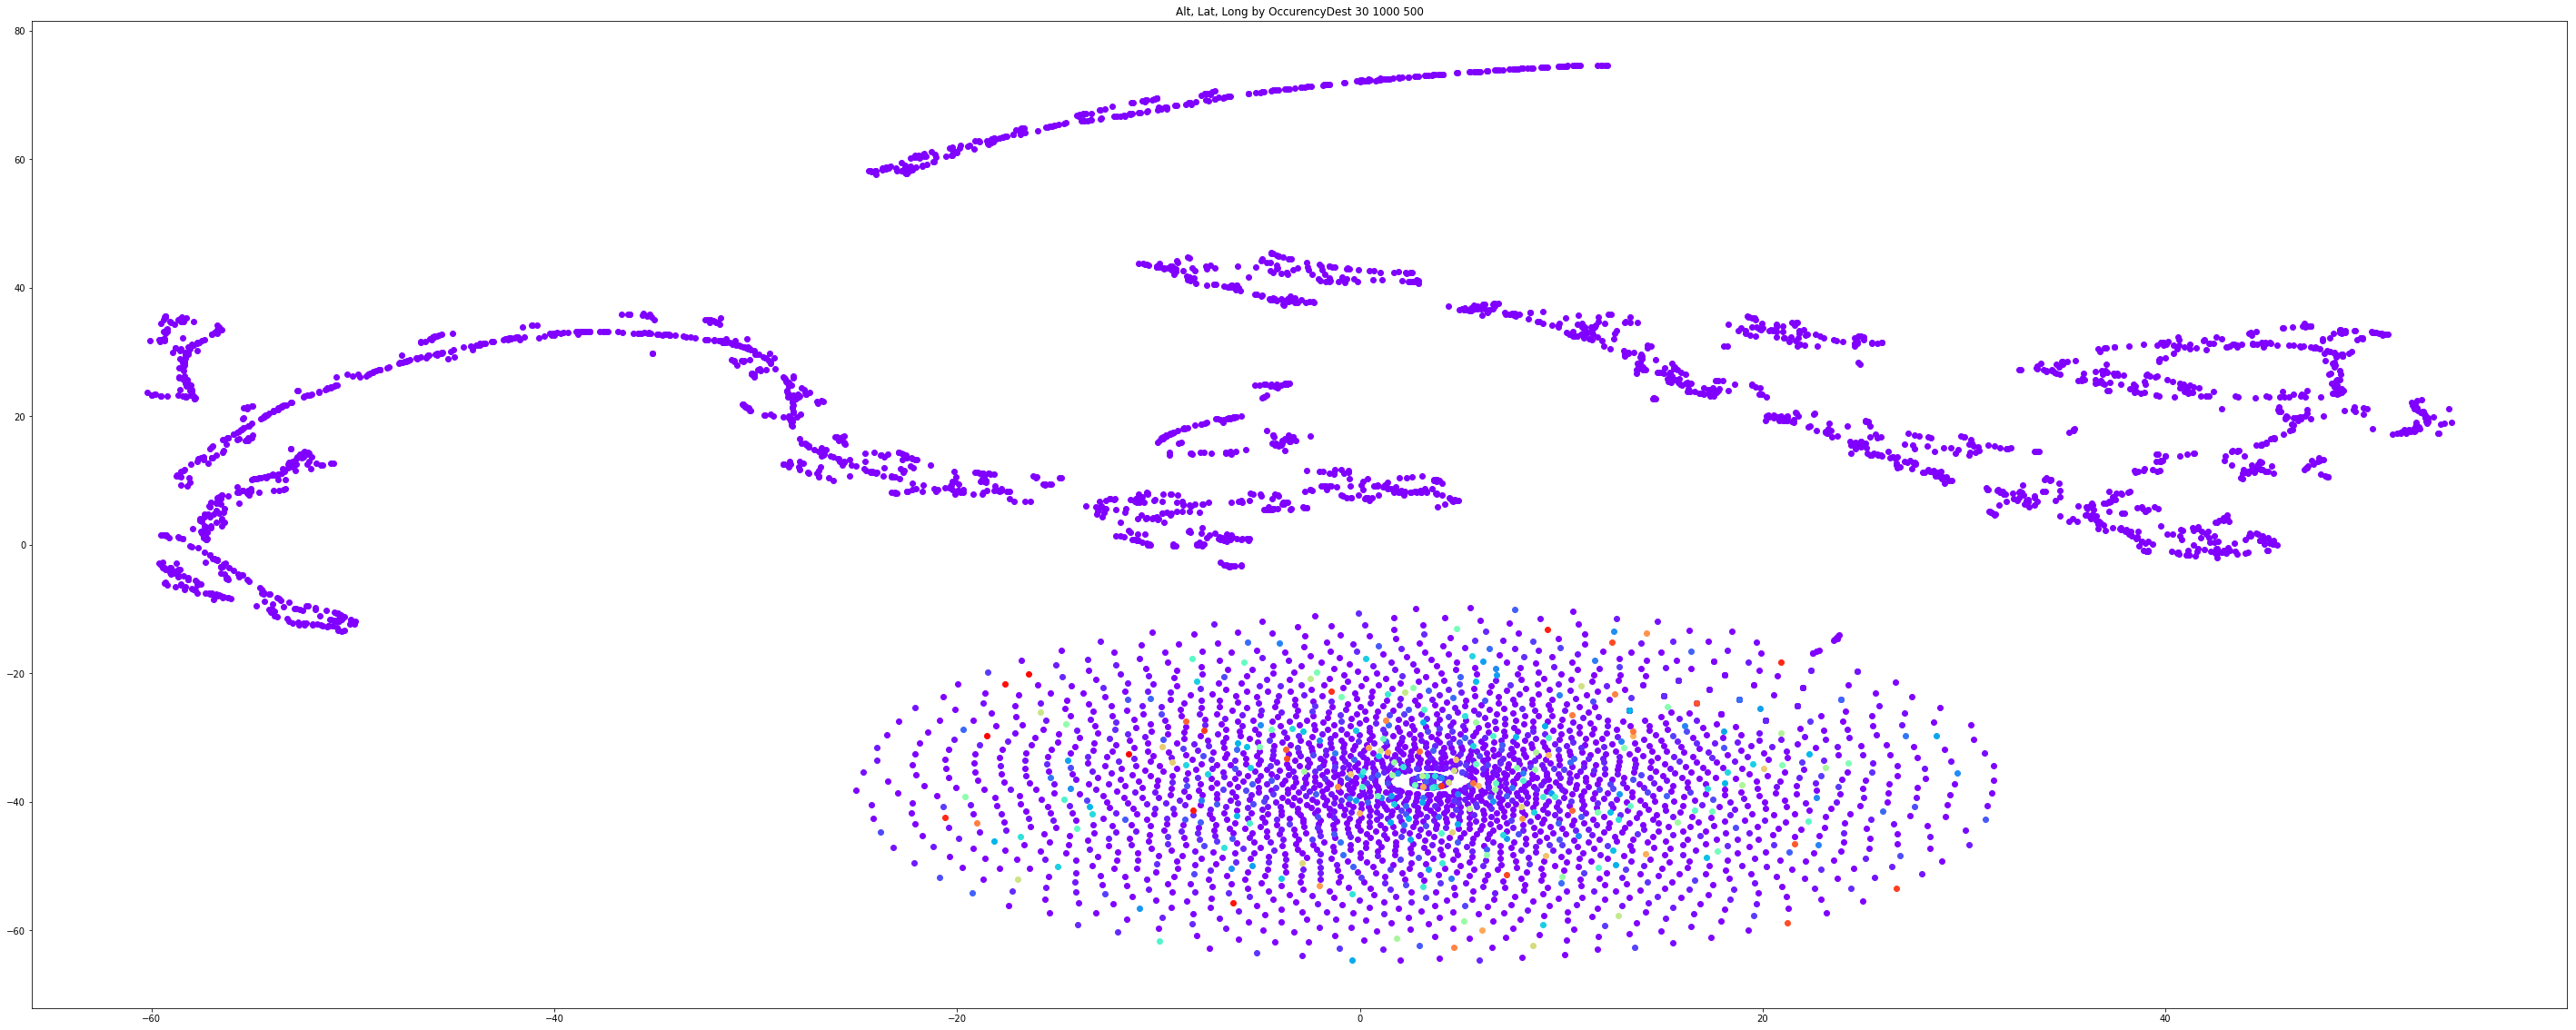

In [44]:
labX = 'OccurencyDest'
labels = lim[labX]
fig = plt.figure()
ax = fig.add_subplot(111)
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
for lab, col in zip(np.unique(labels), colors):
    ax.scatter(Y[labels==lab, 0], Y[labels==lab, 1], color=col)
tit_str = f"Alt, Lat, Long by {labX} {perplexity} {iterations} {learning_rate}"
ax.set_title(tit_str)
plt.savefig(tit_str + '.png')

In [54]:
top_routes = routes[routes['Equipment'].isin(['320', 'CRJ', '737', '738', '73W', 'ERJ'])]
top_routes.head()

Airline AirlineID Source SourceID Dest DestID Codeshare  Stops Equipment  \
187       2P       897    GES     2402  MNL   2397         Y      0       320   
197       2P       897    MNL     2397  GES   2402         Y      0       320   
3952      9W      3000    AUH     2179  TRV   3153         Y      0       320   
3963      9W      3000    BLR     3131  CCU   3043         Y      0       738   
3969      9W      3000    BLR     3131  IDR   3008         Y      0       738   

      SourceLat   SourceLon    DestLat     DestLon     Distance  
187    6.058000  125.096001  14.508600  121.019997  1039.923631  
197   14.508600  121.019997   6.058000  125.096001  1039.923631  
3952  24.433001   54.651100   8.482120   76.920097  2955.215820  
3963  13.197900   77.706299  22.654699   88.446701  1546.839895  
3969  13.197900   77.706299  22.721800   75.801102  1077.956338

In [70]:
perplexity = 35
learning_rate = 200
iterations = 5000
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=iterations)
lim = top_routes.sample(frac=0.4)
labs = ['DestLat', 'DestLon', 'Distance']
Y = tsne.fit_transform(lim[labs])

In [72]:
labX = 'Distance'
labels = lim[labX]
fig = plt.figure()
ax = fig.add_subplot(111)
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
for lab, col in zip(np.unique(labels), colors):
    ax.scatter(Y[labels==lab, 0], Y[labels==lab, 1], color=col, label=lab)
tit_str = f"Routes {' '.join(labs)} by {labX} {perplexity} {iterations} {learning_rate}"
ax.set_title(tit_str)
plt.legend()
plt.savefig(tit_str + '.png')